# Analyzing Change

##### The purpose of this notebook is to analyze how queries changed over time
This wasn't too succesful since when I conducted this analysis, I was missing two months of data from June and July, and ultimately just need to work on it a bit more. 

In [2]:
import pandas as pd

In [3]:
af = pd.read_csv('all_queries_autocomplete.csv',index_col=False)
rf = pd.read_csv('all_queries_related.csv',index_col=False)

In [49]:
af.head()

,Query,Source,Date Added,city,seed_query,candidate,gender,no_seed
0,jon santiago races 2021,autocomplete,2021-04-27,Boston,jon santiago race,jon santiago,M,s 2021
1,isaac wright jr daughter instagram,autocomplete,2021-04-27,NYC,isaac wright jr,isaac wright jr,M,daughter instagram
2,john barros wiki,autocomplete,2021-04-27,Boston,john barros,john barros,M,wiki
3,scott stringer backgrounds,autocomplete,2021-04-27,NYC,scott stringer background,scott stringer,M,s
4,art chang mayor election results 2018,autocomplete,2021-04-27,NYC,art chang,art chang,M,mayor election results 2018


In [4]:
rf.head()

,Query,Source,Date Added,(Num Occurances),city,seed_query,candidate,gender
0,dianne morales stuyvesant,related searches,2021-04-27,NaN,NYC,NaN,dianne morales,W
1,john barros bio,related searches,2021-04-27,NaN,Boston,NaN,john barros,M
2,fernando mateo taxi,related searches,2021-04-27,NaN,NYC,NaN,fernando mateo,M
3,when was isaac wright jr released,related searches,2021-04-27,NaN,NYC,NaN,isaac wright jr,M
4,andrew yang parents,related searches,2021-04-27,NaN,NYC,NaN,andrew yang,M


The vision for this analysis is to group the queries by week, then compare them to the week before, so first we need to add week numbers in as a column

In [5]:
def add_week_num(df):
    #create a temp df that is just a list of all dates 
    week = df[['Date Added']].drop_duplicates()
    week.sort_values(by='Date Added',inplace=True)
    #make a list thats the week number repeated seven times for the number of weeks total
    nums = [[num] * 7 for num in list(range(len(week)//7))]
    nums = sum(nums, [])
    print(len(week))
    print(len(nums))
    
    #some don't match, so we need to extend the length of the latter
    nums.extend([nums[-1]]*(len(week)-len(nums)))
    #now add this week number variable to our temporary df that had all the dates
    week['week'] = nums
    #and merge it back onto our dataframe
    df = pd.merge(df, week, on=['Date Added'], how='left')
    
    return df

rf_b = add_week_num(rf[rf.city=='Boston'])
rf_n = add_week_num(rf[rf.city=='NYC'])

af_b = add_week_num(af[af.city=='Boston'])
af_n = add_week_num(af[af.city=='NYC'])

143
140
140
140
137
133
140
140


In [6]:
rf_b

,Query,Source,Date Added,(Num Occurances),city,seed_query,candidate,gender,week
0,john barros bio,related searches,2021-04-27,NaN,Boston,NaN,john barros,M,0
1,kim janey reading memorial high school,related searches,2021-04-27,NaN,Boston,NaN,kim janey,W,0
2,michelle wu video,related searches,2021-04-27,NaN,Boston,NaN,michelle wu,W,0
3,dana depelteau linkedin,related searches,2021-04-27,NaN,Boston,NaN,dana depelteau,M,0
4,"andrea campbell husband, matthew",related searches,2021-04-27,NaN,Boston,NaN,andrea campbell,W,0
...,...,...,...,...,...,...,...,...,...
84396,michelle wu boston mayor political party,related searches,2021-11-09,NaN,Boston,NaN,michelle wu,W,19
84397,michelle wu mother,related searches,2021-11-09,NaN,Boston,NaN,michelle wu,W,19
84398,where does michelle wu live,related searches,2021-11-09,NaN,Boston,NaN,michelle wu,W,19
84399,michelle wu wikipedia,related searches,2021-11-09,NaN,Boston,NaN,michelle wu,W,19


Now that we have that week variable, we can begin analysis. For each week to week difference, we want to calculate the number of new queries that show up and the number of dropped queries, or queries that were in the first week but not in the second. Similarly, we can also use the Jaccard Similarity to measure how similar the two sets are. 

In [7]:
#with the week variable, now we can begin analysis
def find_unique(df):
    '''takes query type dataframe, returns timeseries of number of new unique queries and number of dropped queries'''
    #new df that will be returned at end of it 
    df_new = pd.DataFrame(columns=['week','week_num','total_num','num_increase','num_decrease'])
    week_dict = {}
    
    
    #make sure it's sorted
    df.sort_values(by=['week'],inplace=True)
    
    #get the first corpus of queries
    lastweek_queries = set(df.Query) #.unique()
    
    #iterate through all following weeks to compare to the previous week's set
    for week in sorted(df.week.unique()[1:]): #exclude the first week
        thisweek = df[df['week']==week]
        thisweek_queries = set(thisweek.Query) 
        
        week_dict[week] = thisweek_queries
        
        
        num_new = len(thisweek_queries - lastweek_queries)
        num_gone = len(lastweek_queries - thisweek_queries) 
        
        jaccard = len(thisweek_queries.intersection(lastweek_queries)) / len(thisweek_queries.union(lastweek_queries))
        
        df_new = df_new.append({'week_num':week, 'total_num':len(thisweek_queries),
                                'week':thisweek['Date Added'].unique()[0], 
                                'num_increase':num_new, 'num_decrease':0-num_gone,
                               'jaccard_index':jaccard},
                 ignore_index=True)
        
        lastweek_queries = thisweek_queries #update for next iteration through
        
    return df_new, week_dict

In [8]:
rf_b_analysis, wdict_rb = find_unique(rf_b)
rf_n_analysis, wdict_rn = find_unique(rf_n)
af_b_analysis, wdict_ab = find_unique(af_b)
af_n_analysis, wdict_an = find_unique(af_n)

In [30]:
rf_n_analysis

,week,week_num,total_num,num_increase,num_decrease,jaccard_index
0,2021-05-09,1,57,0,-1184,0.045931
1,2021-05-18,2,102,102,-57,0.000000
2,2021-05-23,3,53,53,-102,0.000000
3,2021-05-31,4,72,72,-53,0.000000
4,2021-06-07,5,74,74,-72,0.000000
5,2021-06-14,6,71,71,-74,0.000000
6,2021-08-15,7,161,160,-70,0.004329
7,2021-08-20,8,141,46,-66,0.458937
8,2021-08-27,9,139,37,-39,0.573034
9,2021-09-03,10,144,25,-20,0.725610


In [9]:
af_b_analysis

,week,week_num,total_num,num_increase,num_decrease,jaccard_index
0,2021-05-09,1,32,0,-1751,0.017947
1,2021-05-18,2,33,33,-32,0.000000
2,2021-05-30,3,19,19,-33,0.000000
3,2021-06-03,4,33,33,-19,0.000000
4,2021-08-04,5,818,808,-23,0.011891
5,2021-08-10,6,1033,298,-83,0.658602
6,2021-08-15,7,892,166,-307,0.605505
7,2021-08-24,8,281,46,-657,0.250533
8,2021-08-31,9,284,60,-57,0.656891
9,2021-09-07,10,295,62,-51,0.673410


Trying to make a quick visualization to see if there are patterns or anything pops out

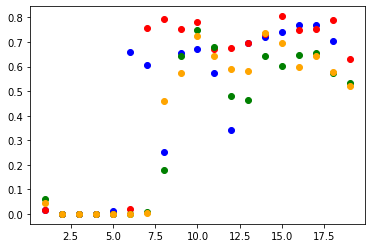

In [10]:
import matplotlib.pyplot as plt
plt.scatter(af_b_analysis['week_num'], af_b_analysis['jaccard_index'], c='blue')
plt.scatter(rf_b_analysis['week_num'], rf_b_analysis['jaccard_index'], c='red')
plt.scatter(af_n_analysis['week_num'], af_n_analysis['jaccard_index'], c='green')
plt.scatter(rf_n_analysis['week_num'], rf_n_analysis['jaccard_index'], c='orange')
plt.show()

Maybe that was too much? Simplify and explore this more in the future!